Since switching over to the stiffness based potential from the energy based version (using $U_{ij}=\frac{k}{2}(\sigma_{ij}-r_{ij})^2$ instead of $U_{ij}=\frac{\varepsilon}{2}(1-\frac{r_{ij}}{\sigma_{ij}})^2$), we now have that __absolute__ overlaps are penalized rather than __relative__ overlaps.  This is a massive benefit.  Previously, the __relative__ overlaps of the energy based potential resulted in us having the same vertex overlaps on the scale of the vertex size for fixed dimensionless temperature $T/\varepsilon$.  When using small vertex sizes, this meant that the particles were effectively much stiffer (vertex overlap is much smaller on the particle scale) and required either using a smaller $\varepsilon$ or a larger $T$ and smaller $\Delta t$.  This made it inconvenient to compare across different parameter combinations and made simulations slower (for the smaller timestep).  Since the vertex overlaps are now all on an __absolute__ scale, we can set a single $T$ for all particle species and expect the same particle-level overlap.

We first require a careful investiation of the __relative__ vertex-level overlap and its dependence on $T/\varepsilon$ ($\varepsilon/\sigma^2=\varepsilon=k$) and $\phi$.  In the cases of the smallest vertex sizes, the vertex-level overlap may exceed the vertex size.  This is obviously something we don't want.  We want to be sure we are in the hard-particle limit where overlaps approximately don't exist.  This was the benefit of using the energy version as this enabled us to directly set the relative overlaps through the temperature.

Here, we will show the temperature and density dependence of the vertex overlap (averaged over all contacting vertices) normalized by the vertex diameter $\langle \delta_v / \sigma_v \rangle_c$ , the pressure $P$, and the potential energy per particle $U/N$.  Afterwards, we will show the dependence of dynamic (time-dependent) quantities (i.e. the MSD) on the temperature.  HP behavior is approximately obtained when further decreasing the temperature results in little appreciable change in time-dependent behavior, when time is normalized as $t \sqrt{T}$ - normalized by the thermal time.  The aim is to determine a region of $phi$ and a value of $T$ that determines the beginning of the HP limit.  We will then use these values for our more detailed dynamics runs later.  We want to be right at the beginning of the HP limit because it is increasingly computationally expensive to go into lower temperatures.

In [167]:
import numpy as np
from pydpmd.data import RigidBumpy, load
from pydpmd.plot import draw_particles_frame, create_animation, downsample
from correlation_functions import compute_msd, compute_shear_modulus, compute_rotational_msd, compute_pair_correlation_function
from pydpmd.calc import run_binned, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import re
from tqdm import tqdm

# Show Region of $(\phi, T)$ Where $\delta_v/\sigma_v, P, V/N$ Are Small - corresponding to Hard Particle (HP) behavior

In [172]:
hp_root = '/home/mmccraw/dev/data/09-27-25/finding-hard-particle-limit/'
avg_dim_overlap_hist = []
nv_hist = []
mu_hist = []
temp_hist = []
p_hist = []
pe_per_particle_hist = []
phi_hist = []
msd_hist = []
t_hist = []
for T_root in os.listdir(hp_root):
    T_root = os.path.join(hp_root, T_root)
    for run_name in os.listdir(T_root):
        if 'dynamics_' not in run_name:
            continue
        run_dir = os.path.join(T_root, run_name)
        try:
            data = load(run_dir, location=['final', 'init'], load_trajectory=True, load_full=True)
        except:
            continue
        data.calculate_mu_eff()
        overlaps = data.trajectory.overlaps.copy()
        summed_overlaps = np.sum(np.add.reduceat(overlaps, data.vertex_system_offset[:-1], axis=1), axis=0)
        avg_overlap = summed_overlaps[:, 0] / summed_overlaps[:, 1]
        vertex_diam = 2 * data.vertex_rad[data.vertex_system_offset[:-1]]
        avg_dimless_overlap = avg_overlap / vertex_diam
        nv = data.n_vertices_per_particle[data.system_offset[:-1]]
        mu = data.mu_eff[data.system_offset[:-1]]
        temp = np.mean(data.trajectory.temperature, axis=0)
        p = np.mean(data.trajectory.pressure, axis=0)
        pe_per_particle = np.mean(data.trajectory.pe_total, axis=0) / data.system_size
        phi = data.packing_fraction.copy()

        msd_path = os.path.join(run_dir, 'msd.npz')
        msd, t = compute_msd(data, msd_path)

        avg_dim_overlap_hist.append(avg_dimless_overlap)
        nv_hist.append(nv)
        mu_hist.append(mu)
        temp_hist.append(temp)
        p_hist.append(p)
        pe_per_particle_hist.append(pe_per_particle)
        phi_hist.append(phi)
        msd_hist.append(msd)
        t_hist.append(t)

avg_dim_overlap_hist = np.array(avg_dim_overlap_hist)
nv_hist = np.array(nv_hist)
mu_hist = np.array(mu_hist)
temp_hist = np.array(temp_hist)
p_hist = np.array(p_hist)
pe_per_particle_hist = np.array(pe_per_particle_hist)
phi_hist = np.array(phi_hist)
msd_hist = np.array(msd_hist)
t_hist = np.array(t_hist)


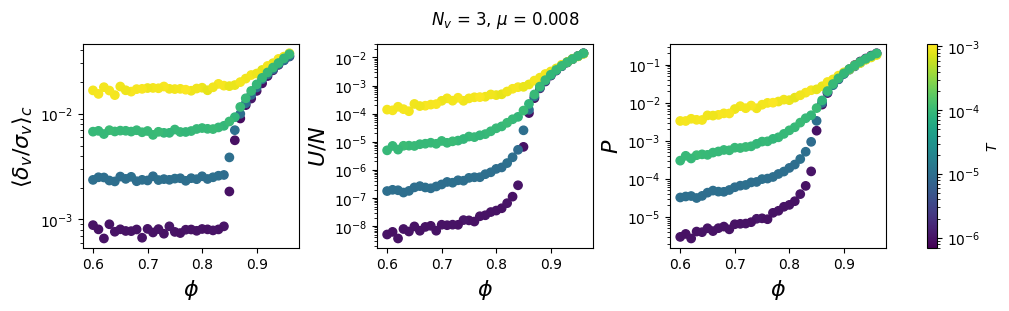

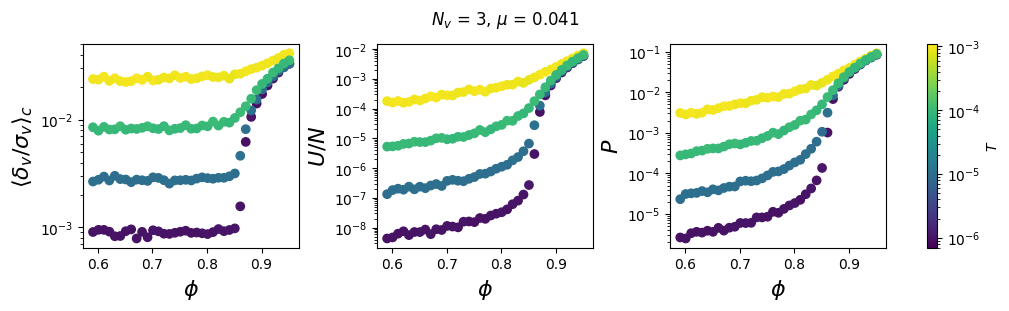

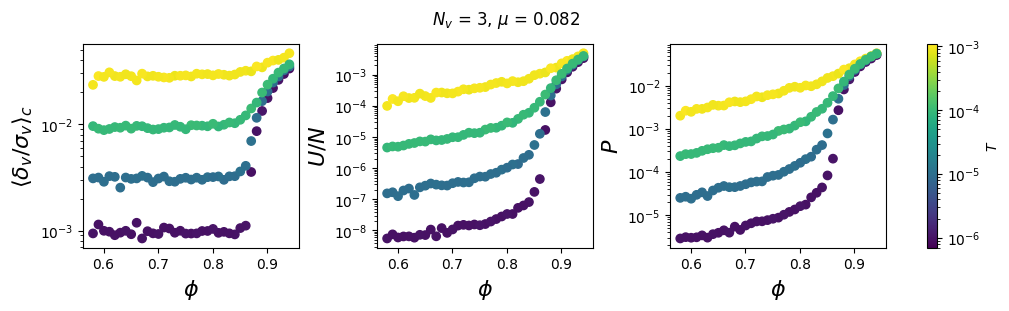

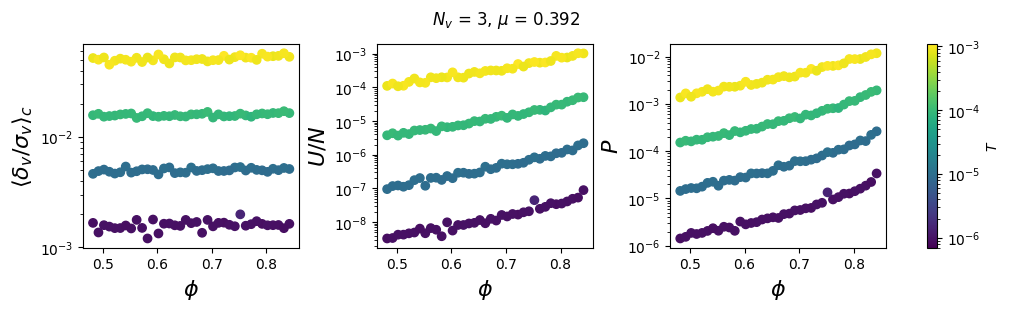

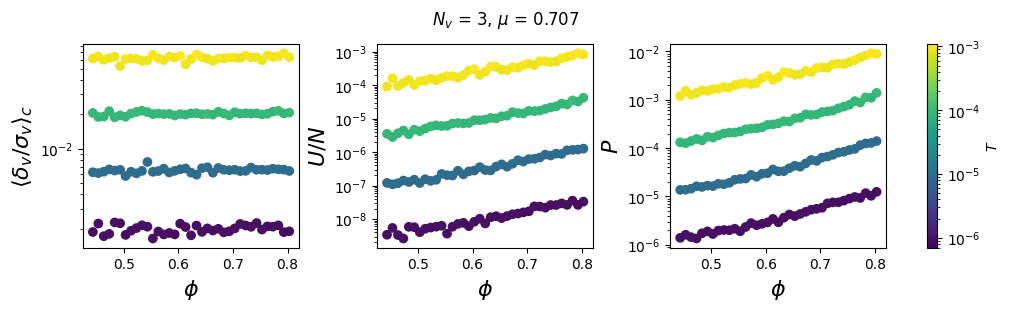

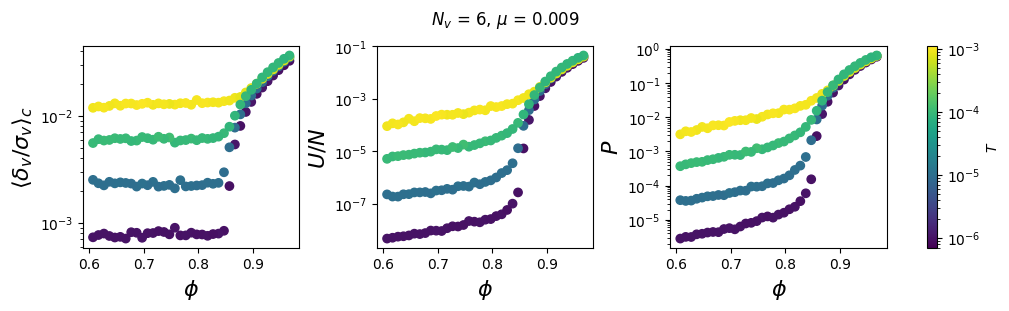

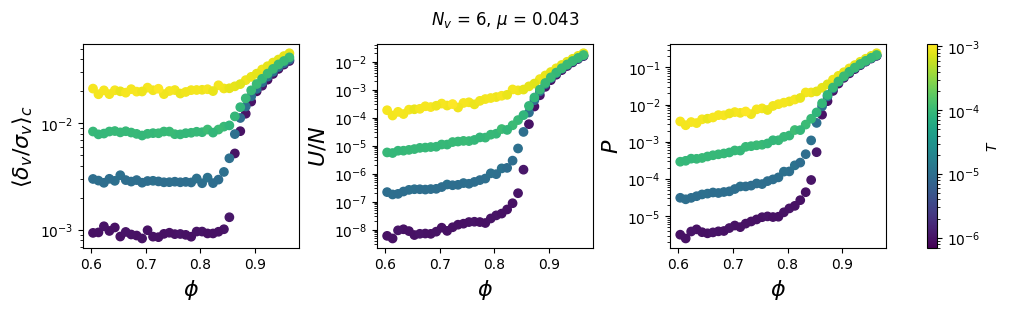

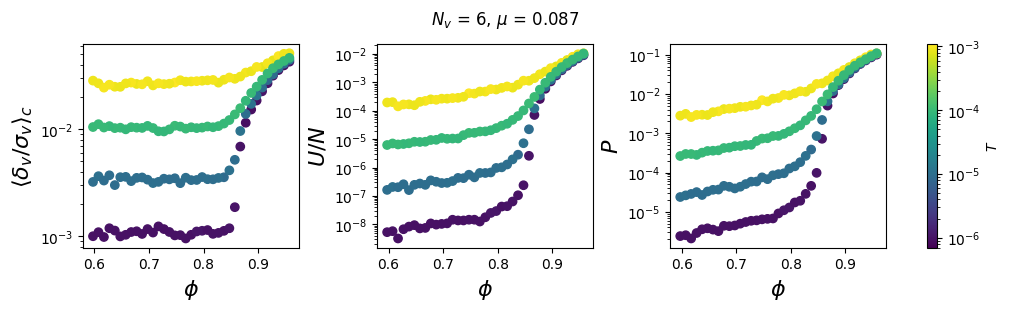

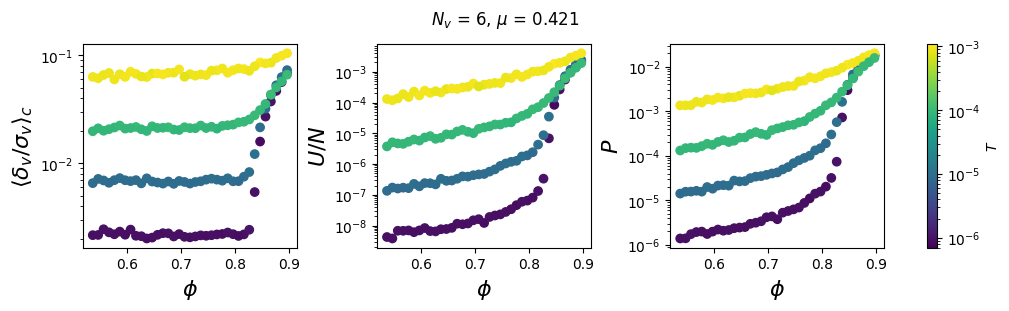

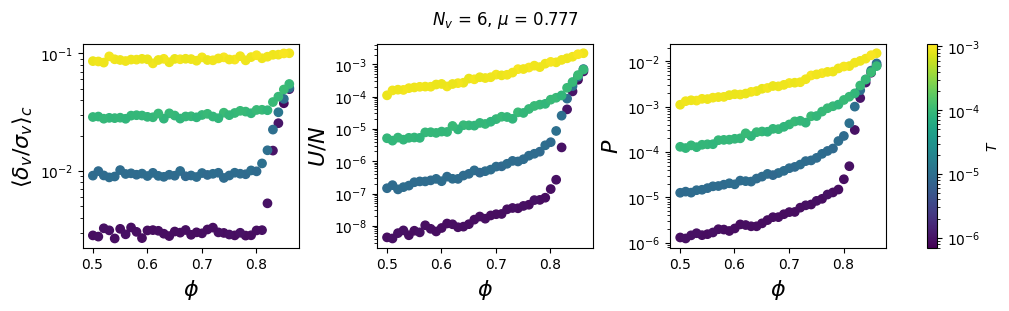

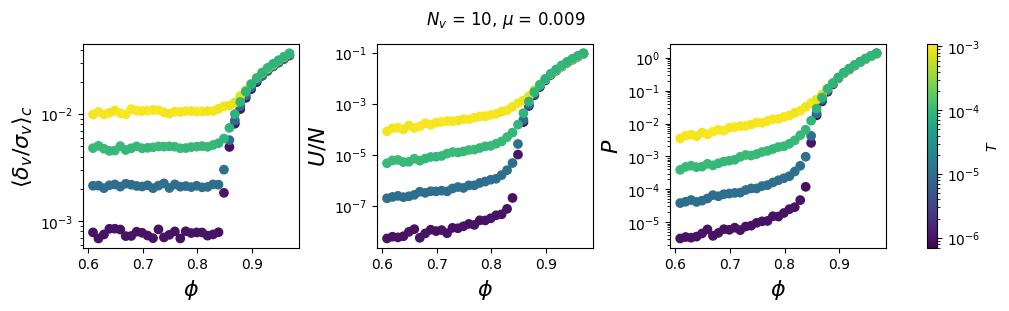

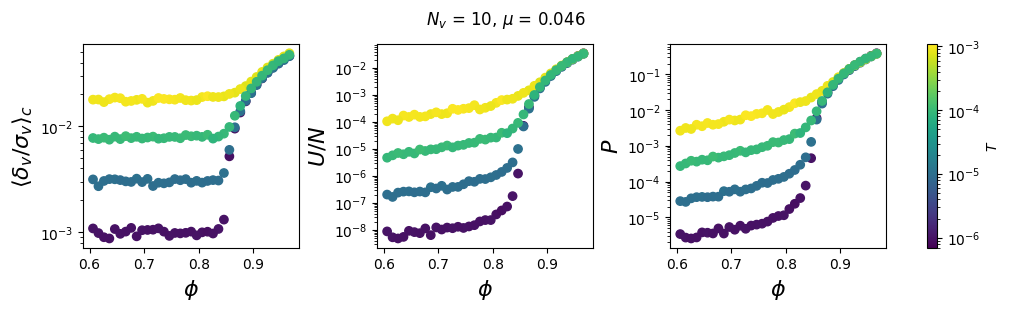

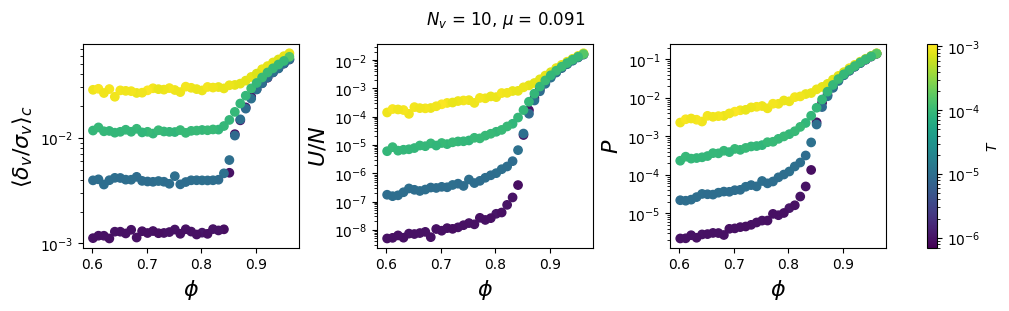

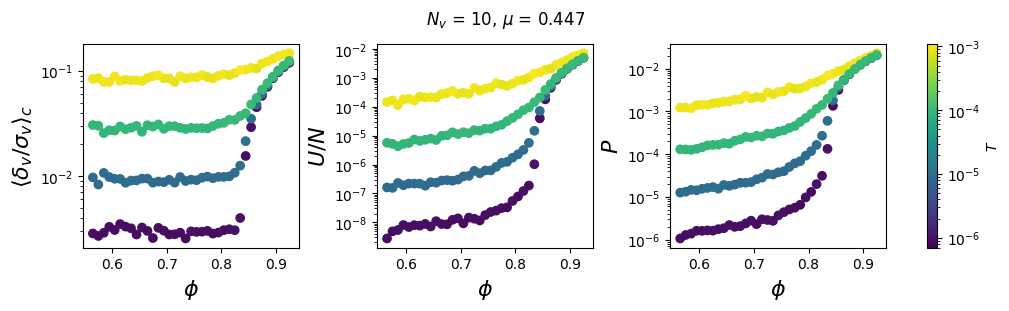

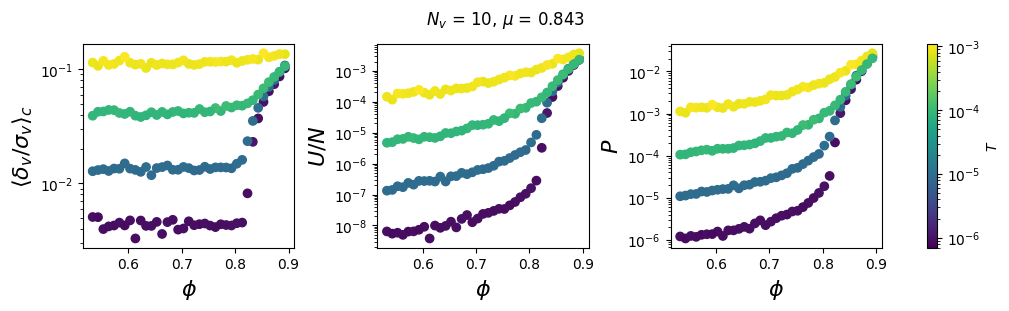

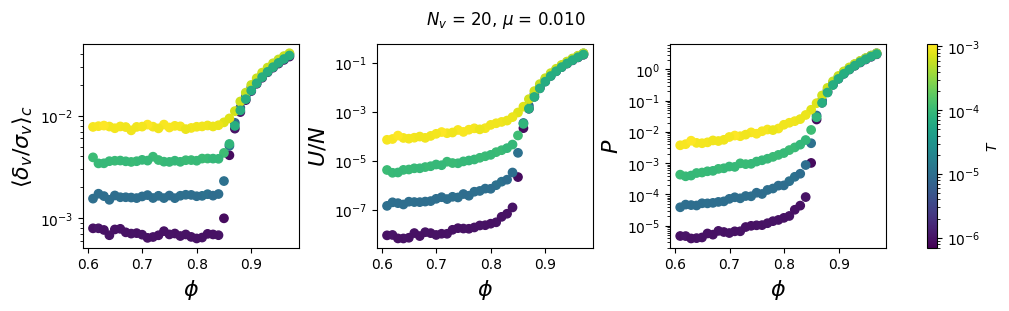

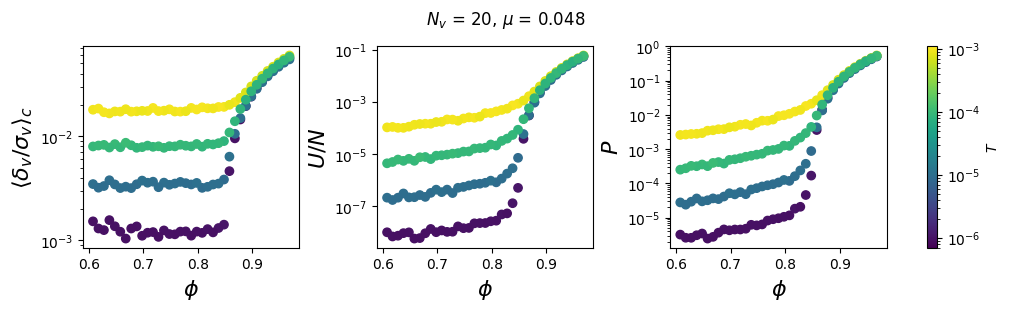

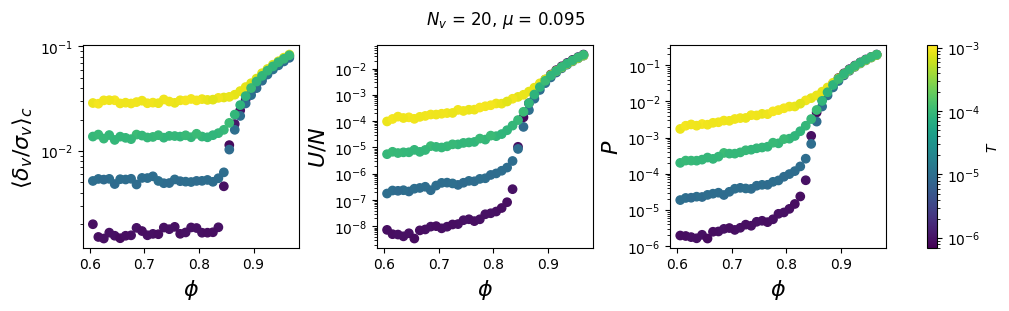

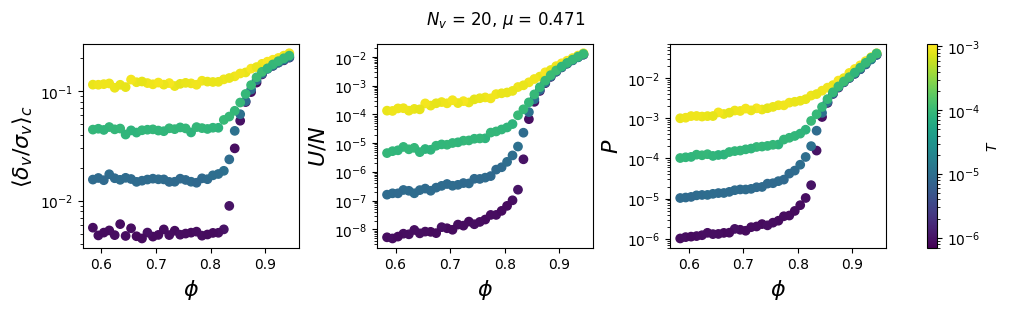

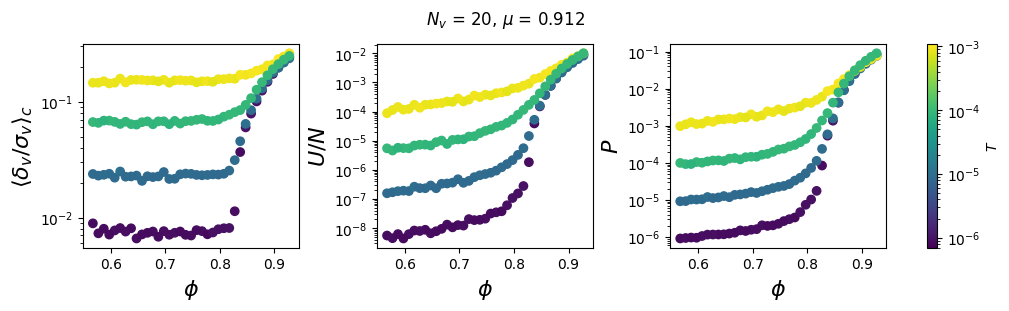

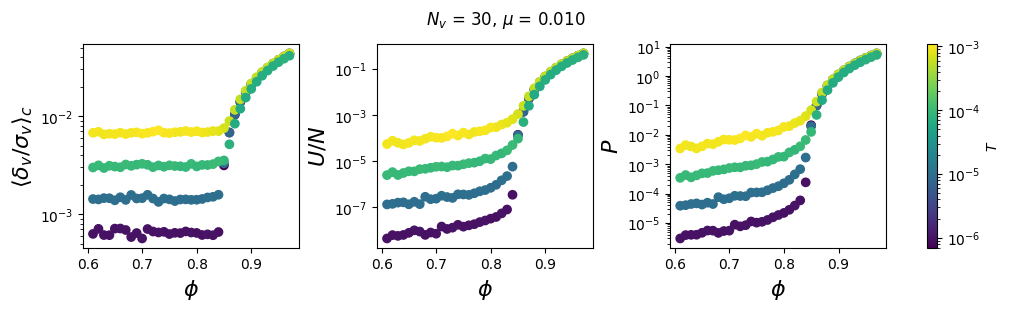

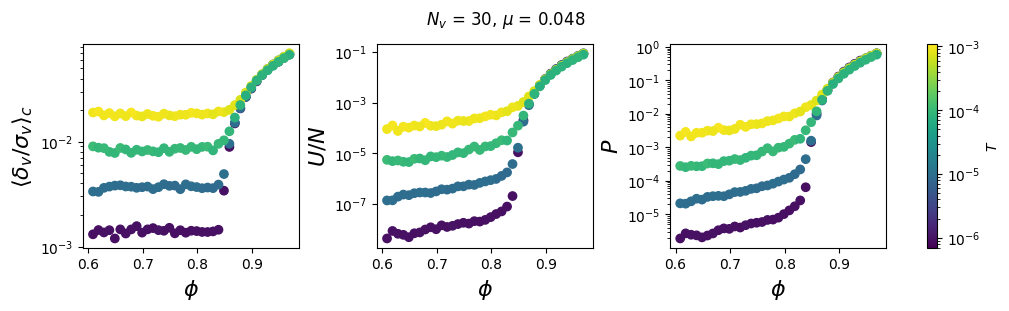

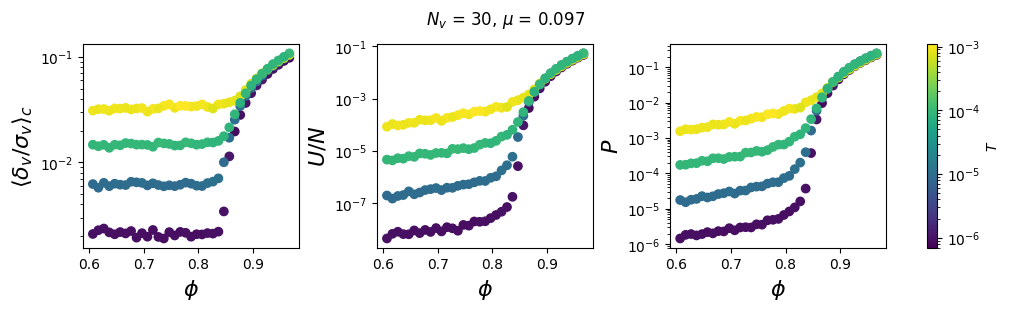

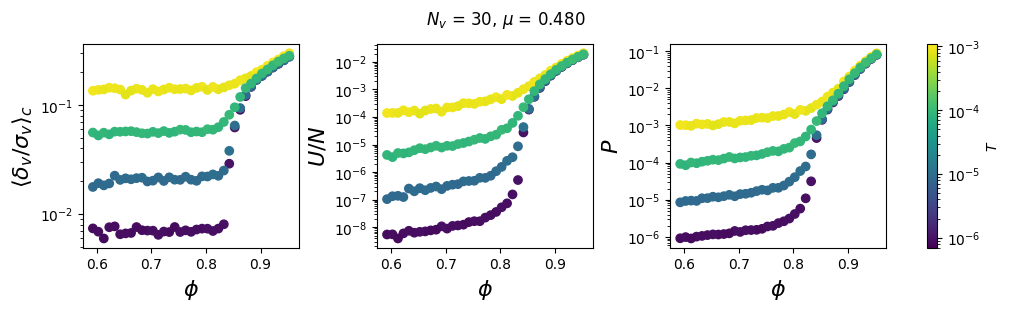

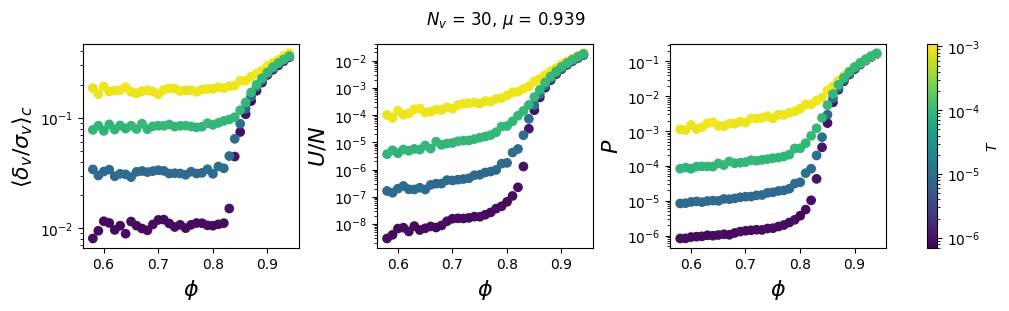

In [325]:
cmap = plt.cm.viridis
norm = LogNorm(vmin=temp_hist.min(), vmax=temp_hist.max())
unique_params = np.unique(np.column_stack((nv_hist.flatten(), mu_hist.flatten())), axis=0)
for nv, mu in unique_params:
    mask = (nv_hist == nv) & (mu_hist == mu)
    fig, ax = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)
    ax[0].scatter(phi_hist[mask], avg_dim_overlap_hist[mask], c=cmap(norm(temp_hist[mask])))
    ax[0].set_ylabel(r'$\langle \delta_v / \sigma_v \rangle_c$', fontsize=16)
    ax[1].scatter(phi_hist[mask], pe_per_particle_hist[mask], c=cmap(norm(temp_hist[mask])))
    ax[1].set_ylabel(r'$U / N$', fontsize=16)
    ax[2].scatter(phi_hist[mask], p_hist[mask], c=cmap(norm(temp_hist[mask])))
    ax[2].set_ylabel(r'$P$', fontsize=16)
    for a in ax:
        a.set_yscale('log')
        a.set_xlabel(r'$\phi$', fontsize=16)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}, $\mu$ = {mu:.3f}')
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(temp_hist[mask])
    cbar = plt.colorbar(sm, ax=ax, label=r'$T$')
    plt.savefig(f'hp-limit-figures/overlaps-pe-pressure/nv-{int(nv) - 1}-mu-{mu:.3f}.png', dpi=300)
    plt.show()


The most important case to look at is the highest friction case with the most number of vertices.  Roughly, friction corresponds to decreasing vertex size relative to the particle size AND increasing the spacing between adjacent vertices.  Furthermore, increasing the number of vertices at fixed friction corresponds to further decreasing the relative vertex size.  For example, the vertices of the $\mu_{eff}~1, N_v=30$ particles are tiny and would be easily dwarfed by the particle-scale overlaps if the temperature is set too high.

To achieve a worst-case scenario relative vertex overlap of $10^{-2}$, it looks like we need $T~10^{-6}$.  In pretty much all other cases, this will give us a relative vertex overlap of $~10^{-3}$ or less.  Otherwise, it seems that $10^{-5}$ would be a good option.

The only way to tell for sure is by comparing the dynamic quantities, which we will do below.

# Show range of $T$ where further decreasing $T$ does not alter dynamics ($MSD$ doesn't change)

Using the data from above, we will calculate the diffusion constant $D$ from the diffusive regime of the translational $MSD$.  The problem here is that many runs fail to reach the diffusive regime.  We will still get our best estimates and as added precaution, we will also report the scaling exponent $n$ for $MSD~D t^n$.  When looking at the figures, we know that whenever $n\neq 1$, the fit is poor and the $D$ value for that particular $(\phi, T)$ should not be interpreted.  Otherwise, we should look carefully at the values of $T$ which cause $D$ to be unchanged.

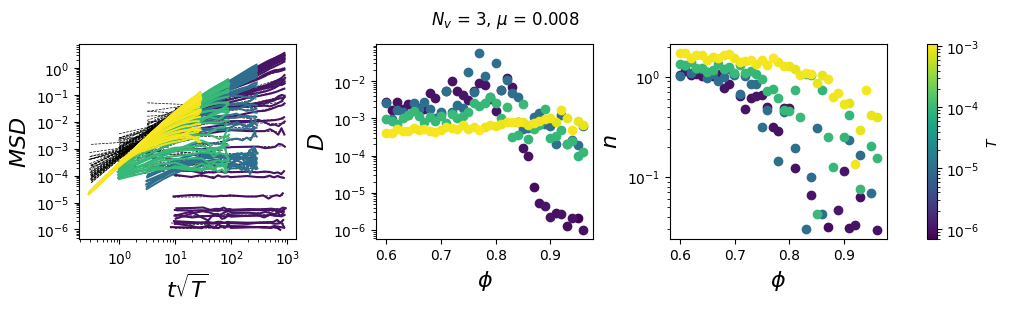

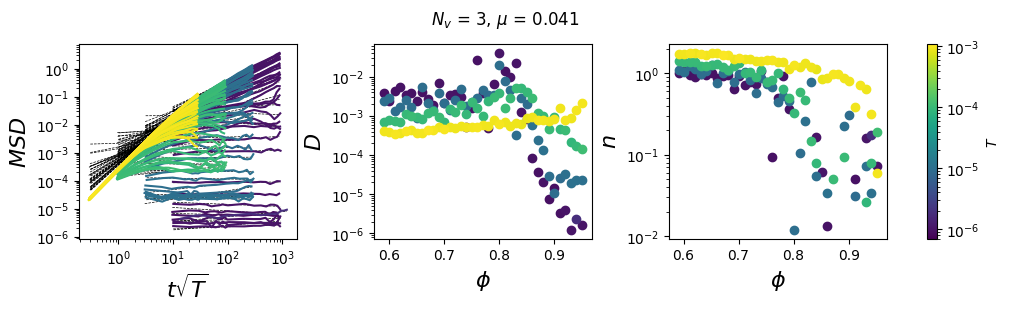

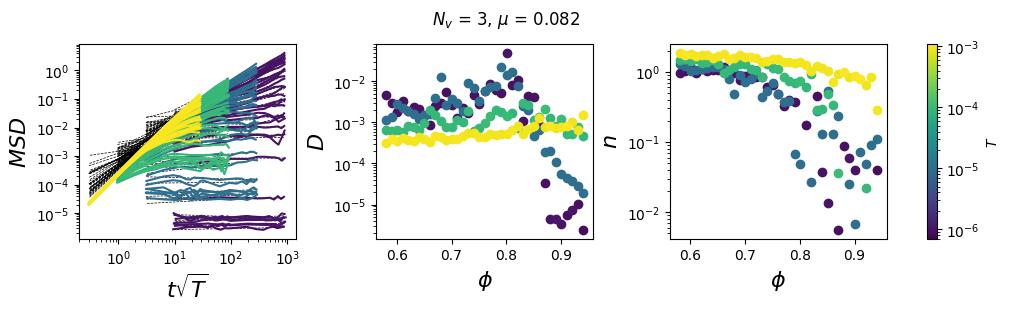

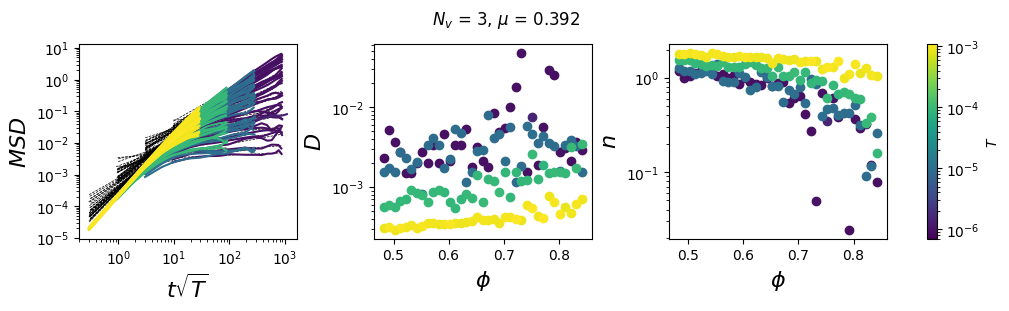

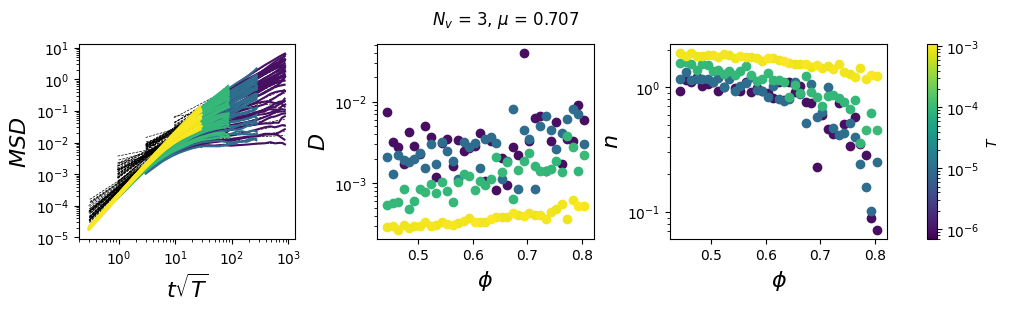

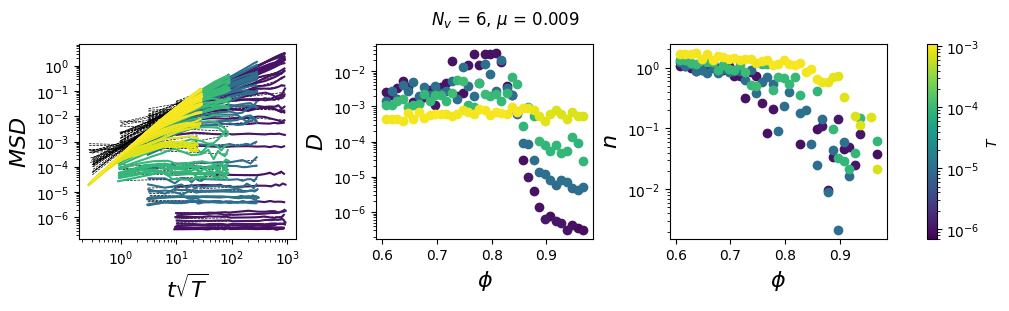

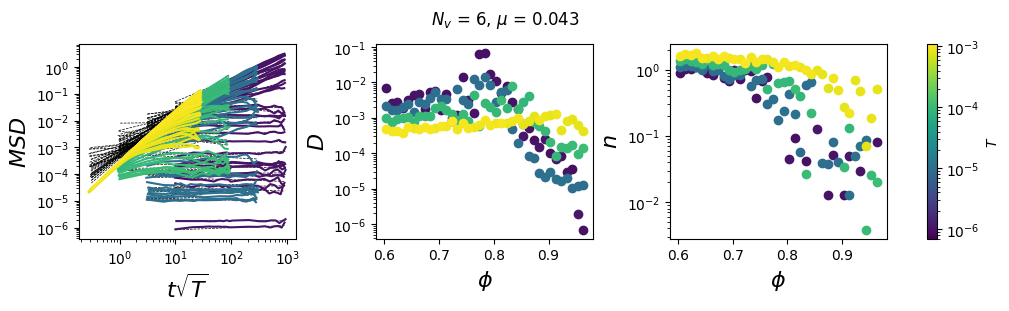

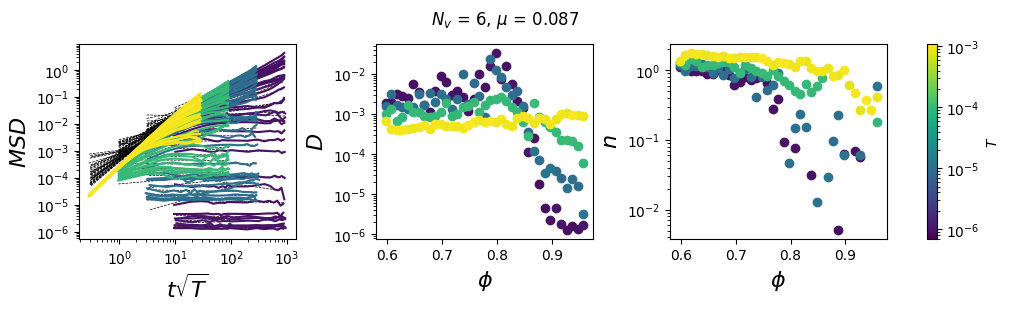

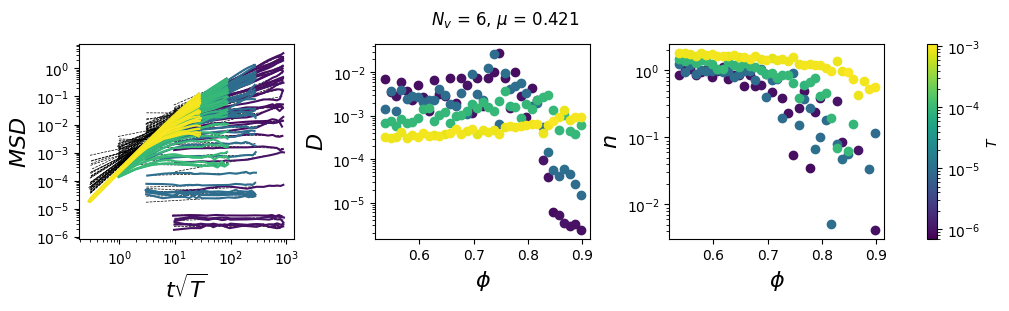

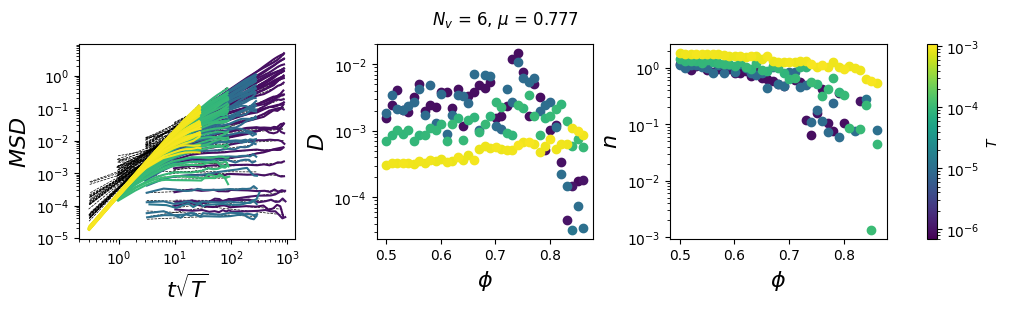

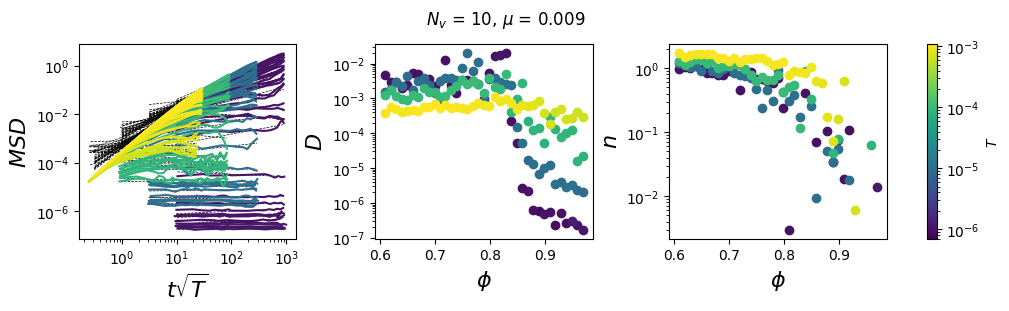

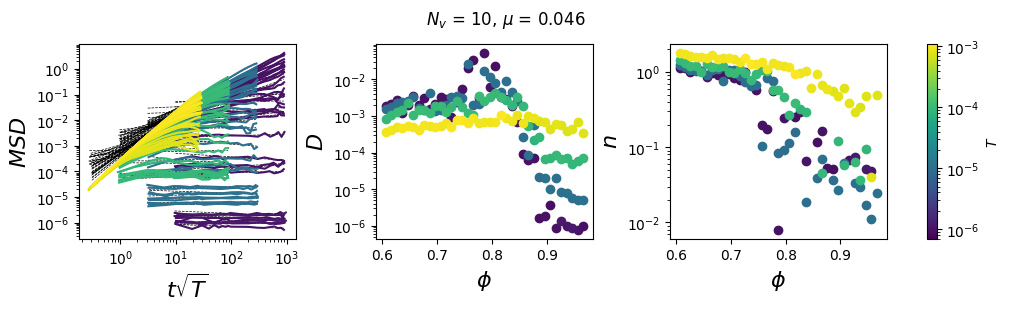

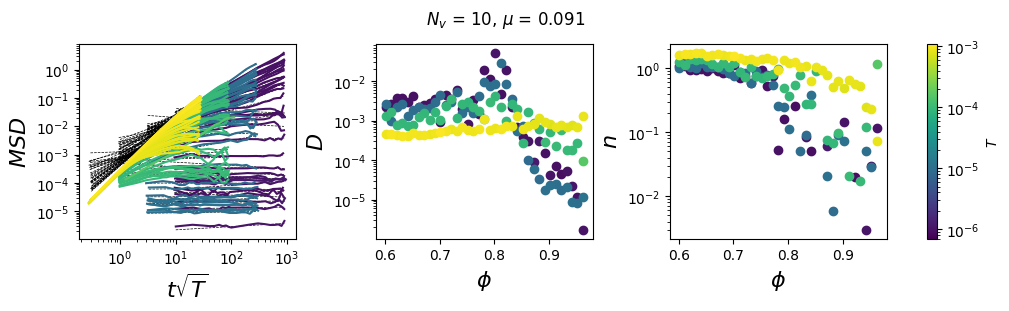

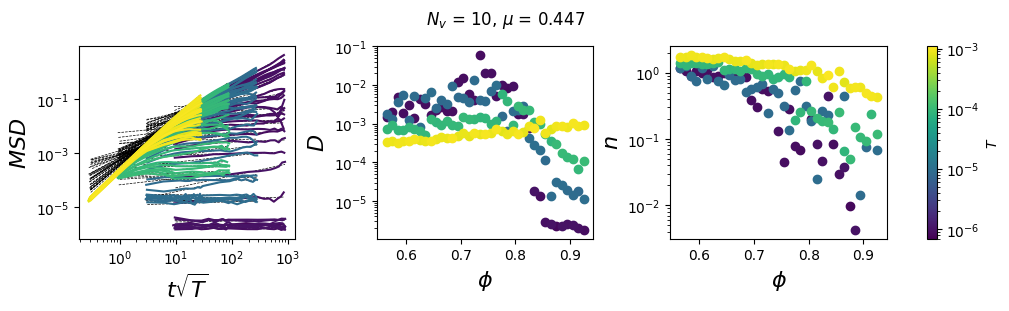

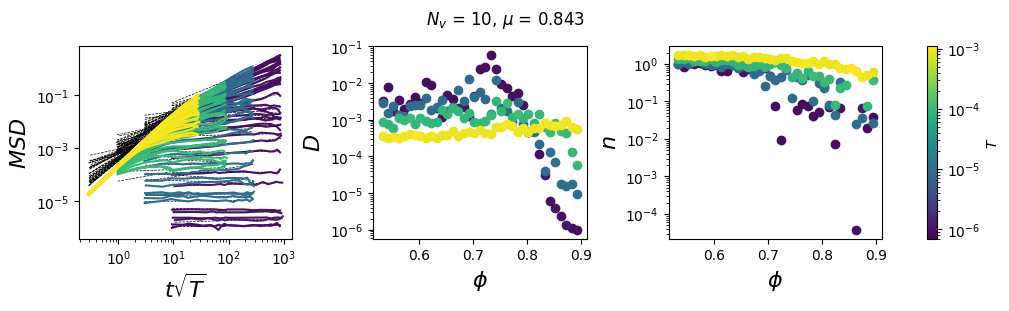

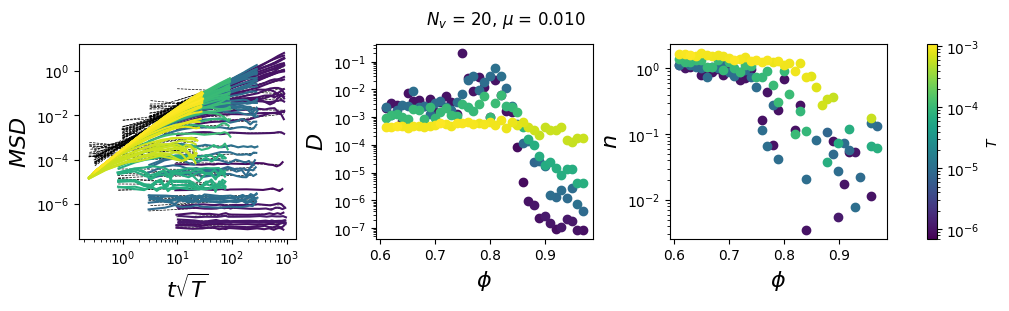

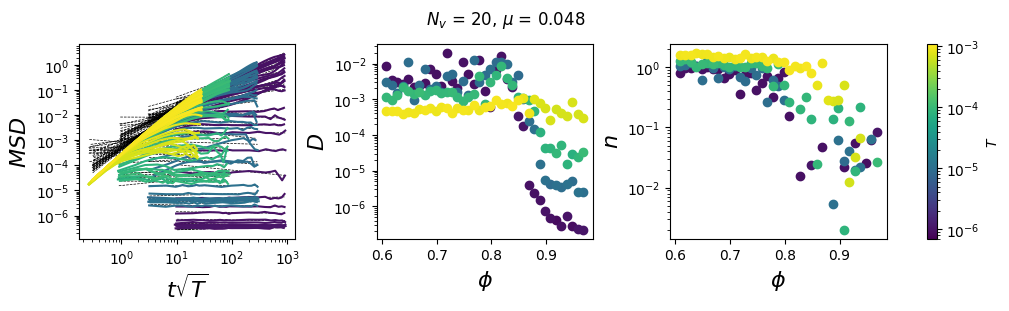

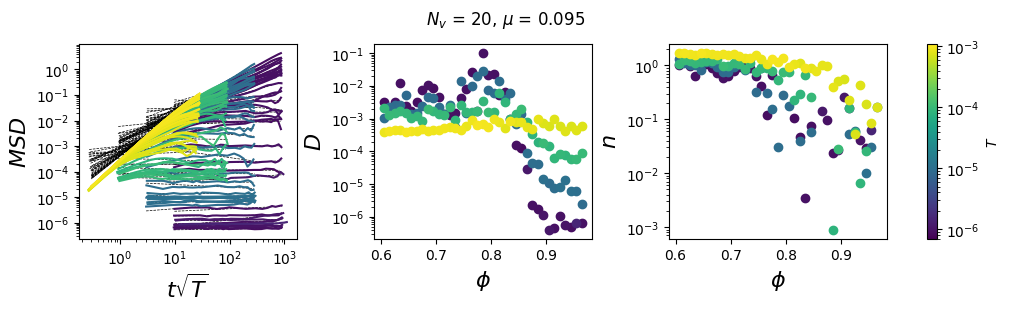

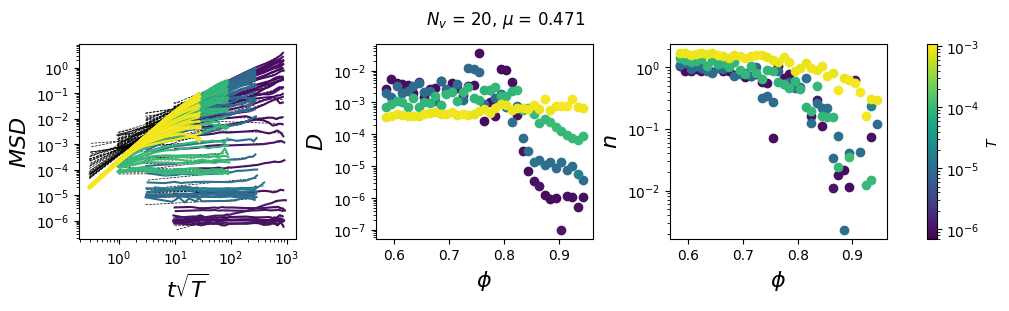

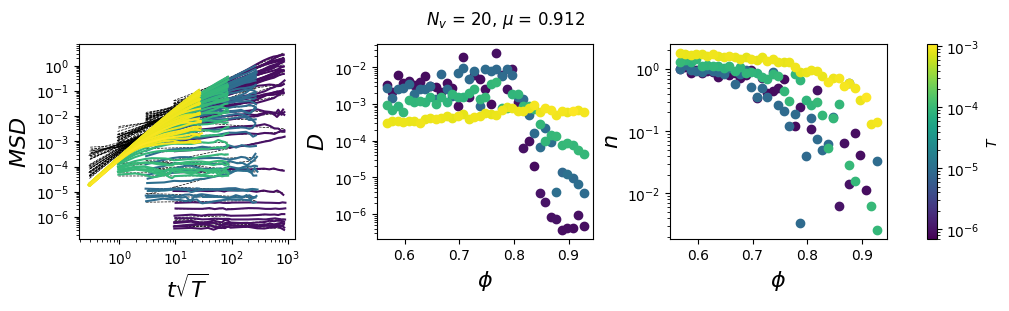

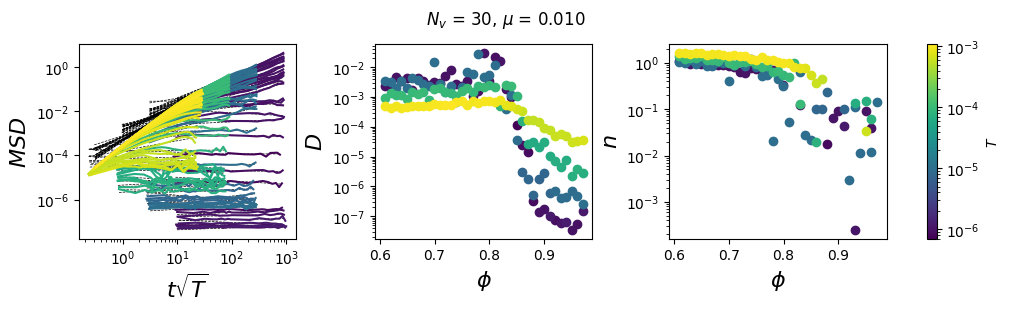

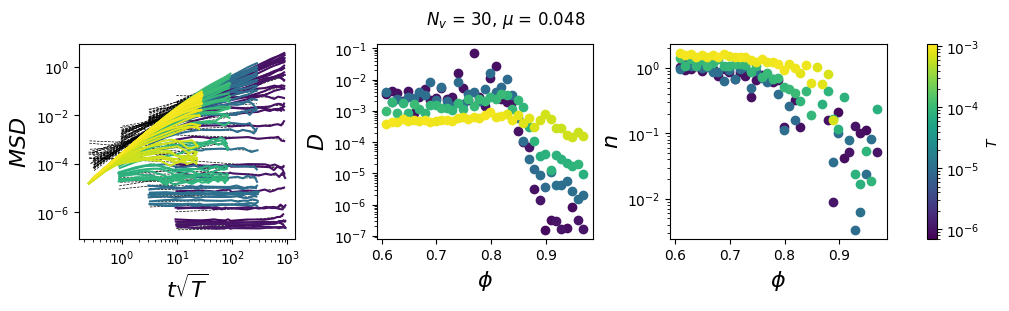

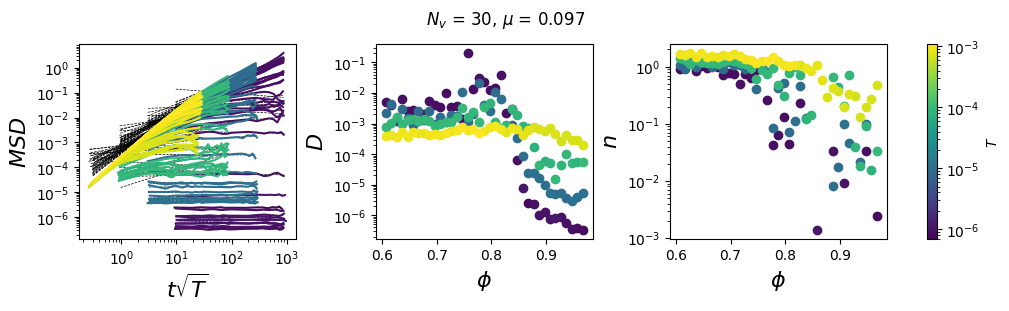

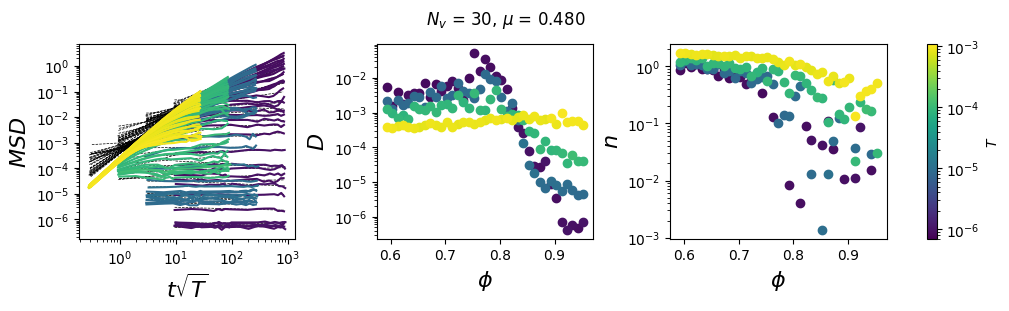

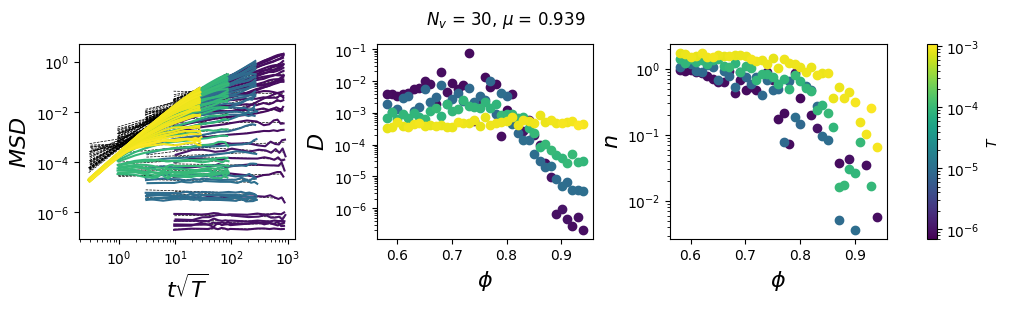

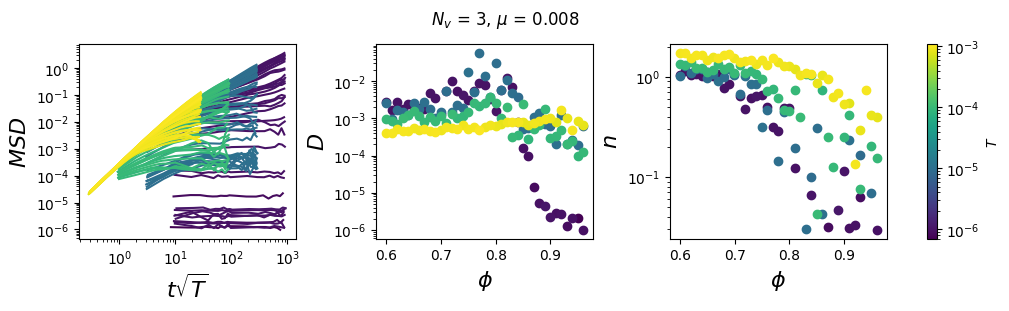

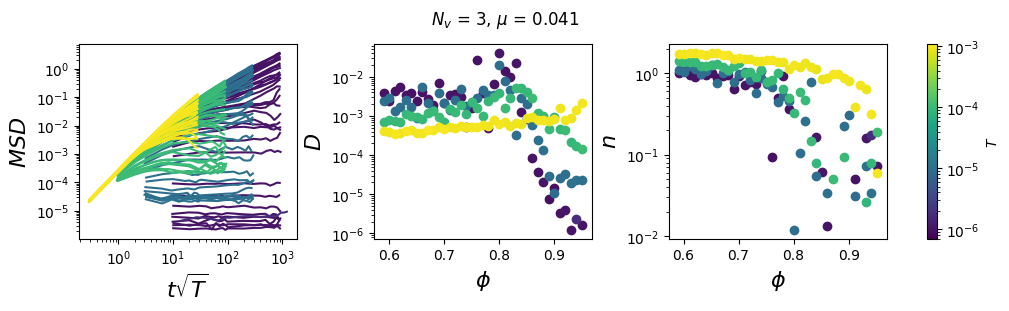

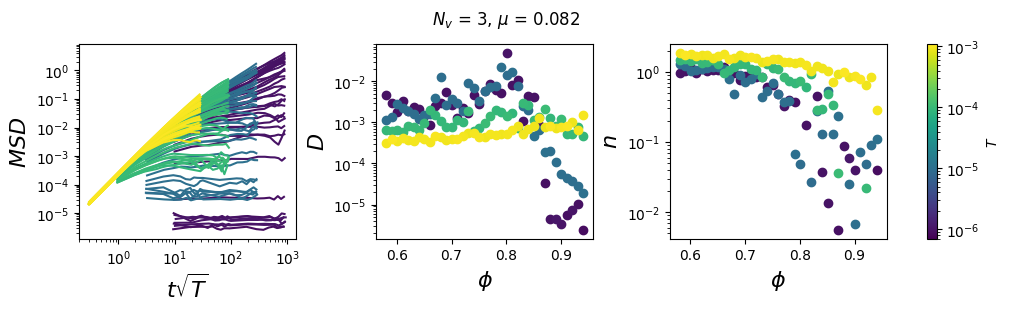

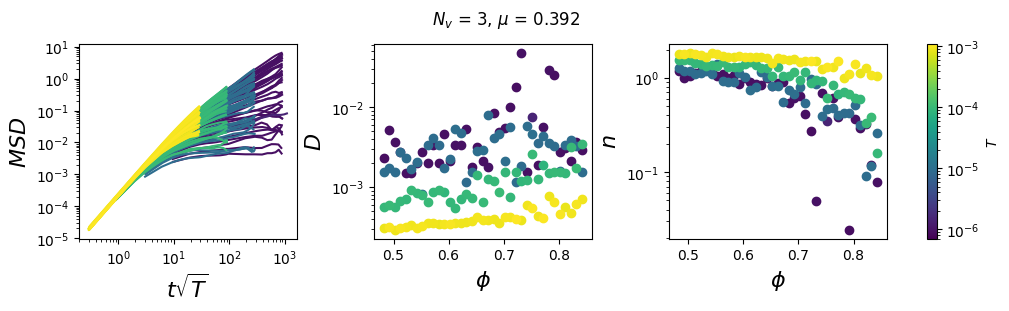

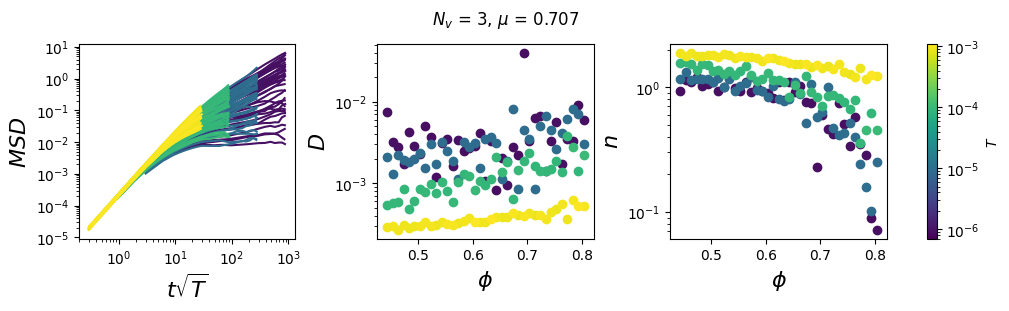

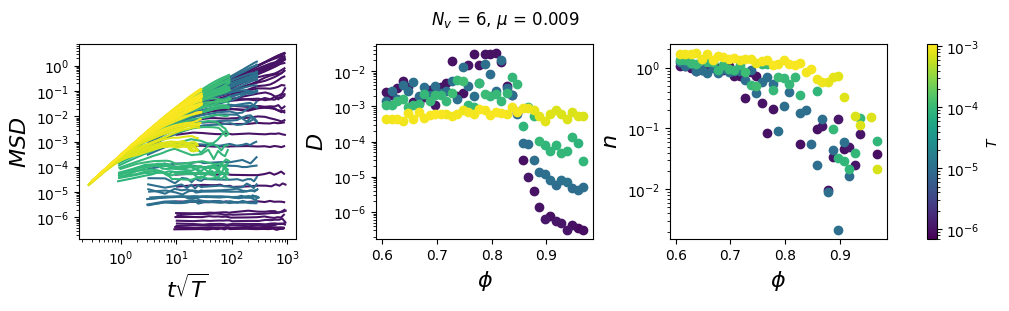

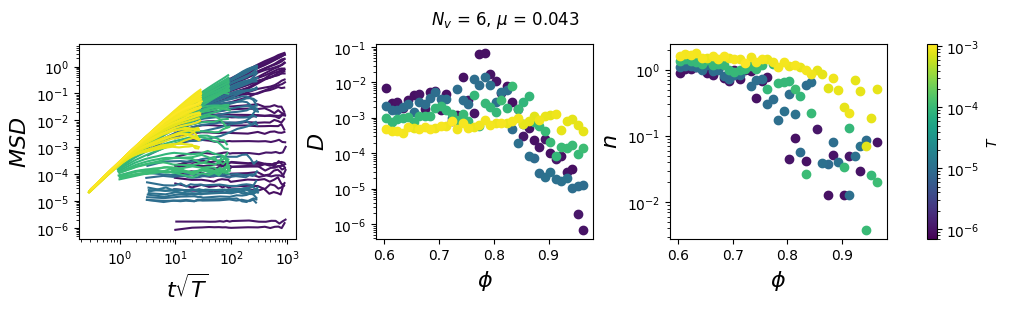

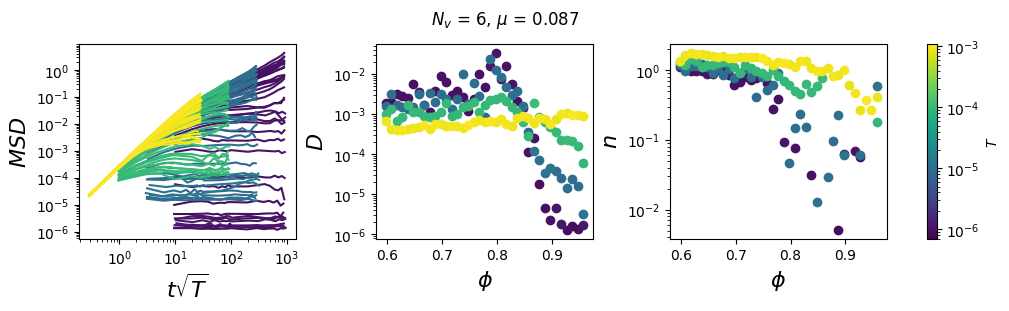

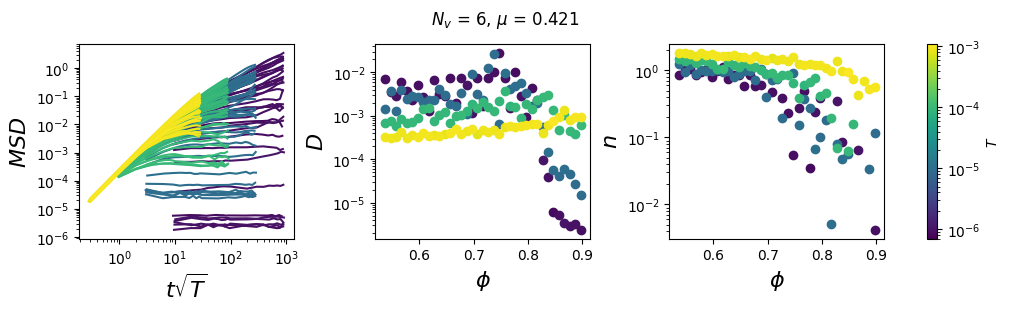

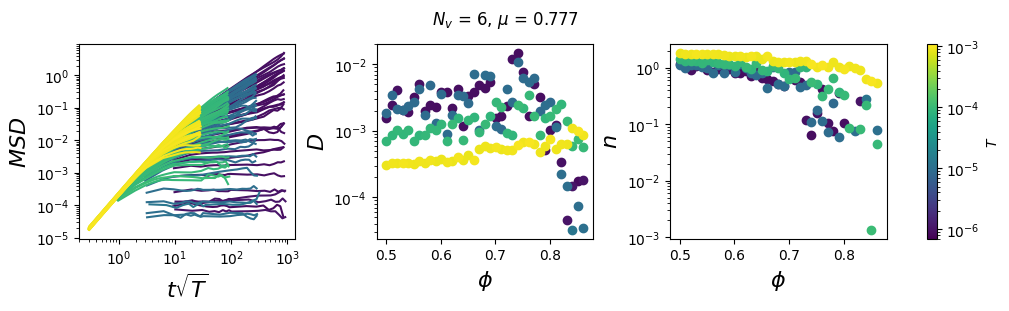

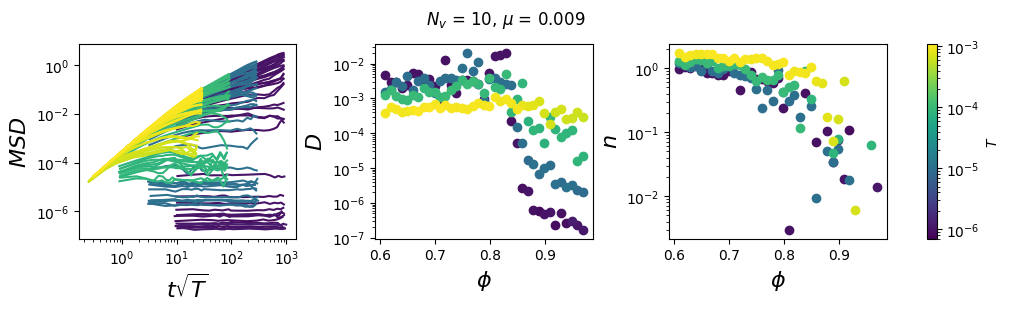

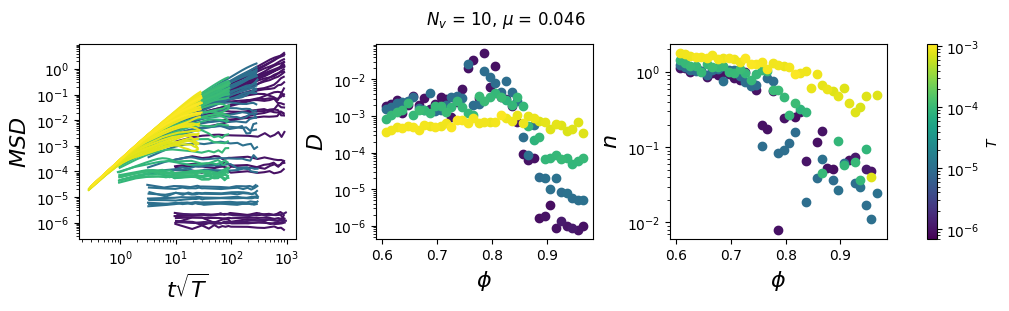

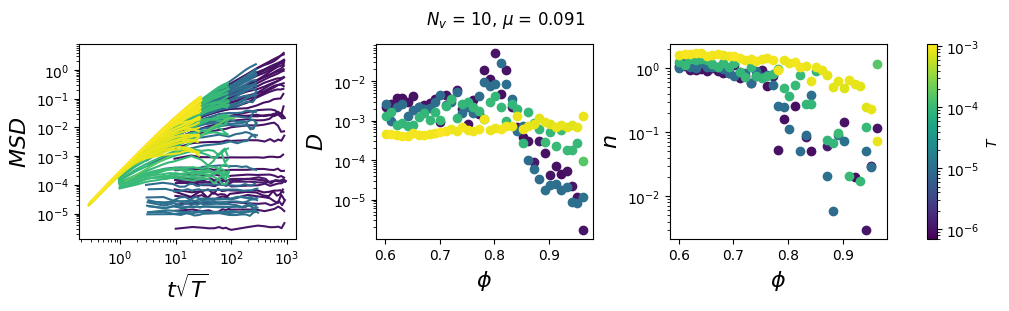

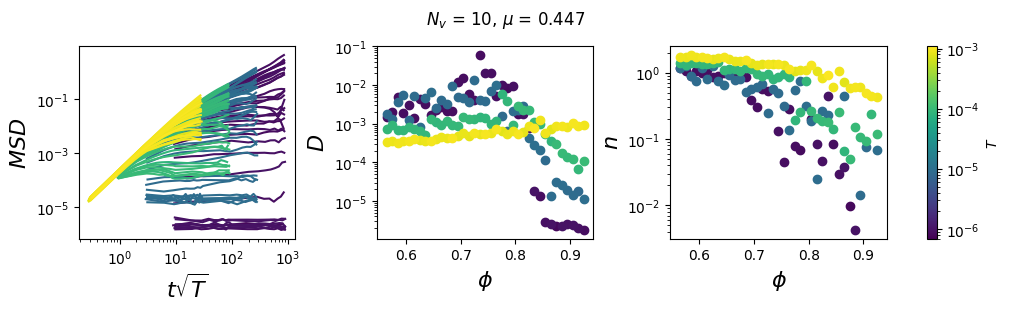

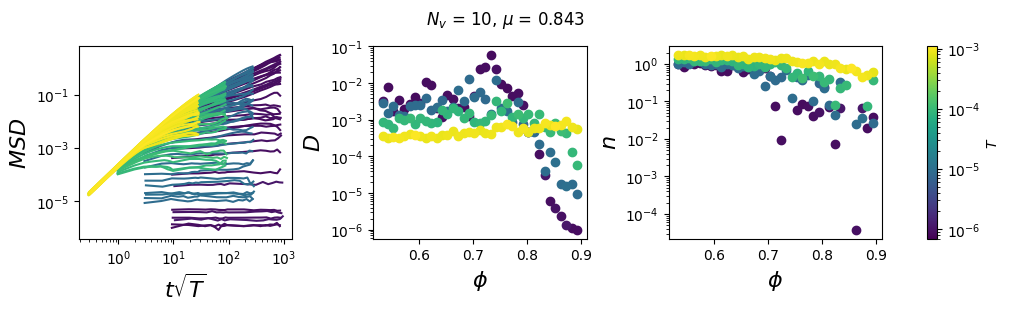

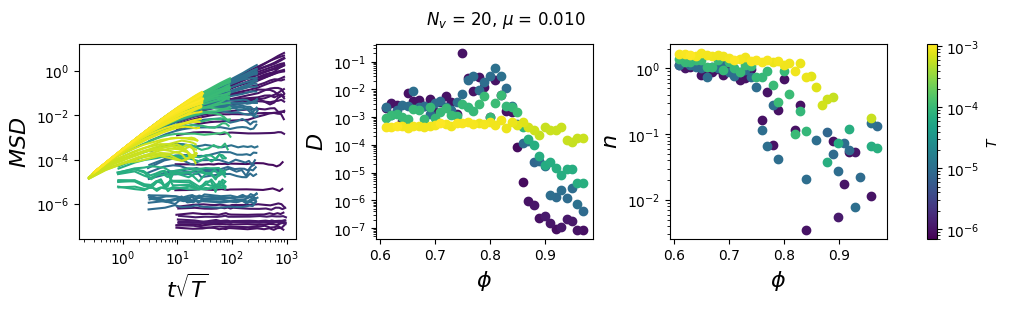

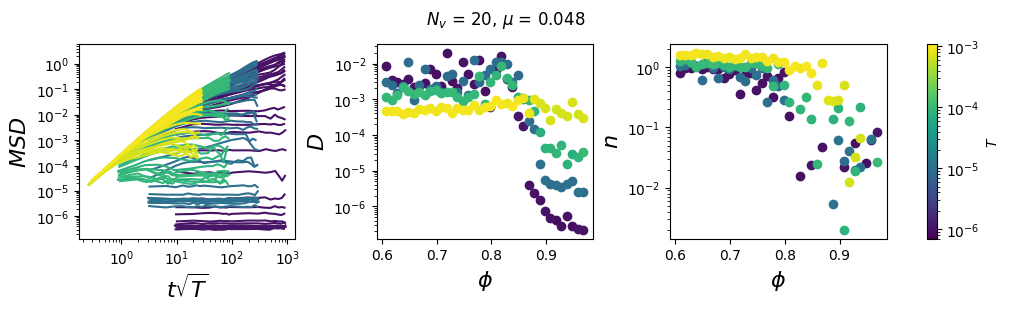

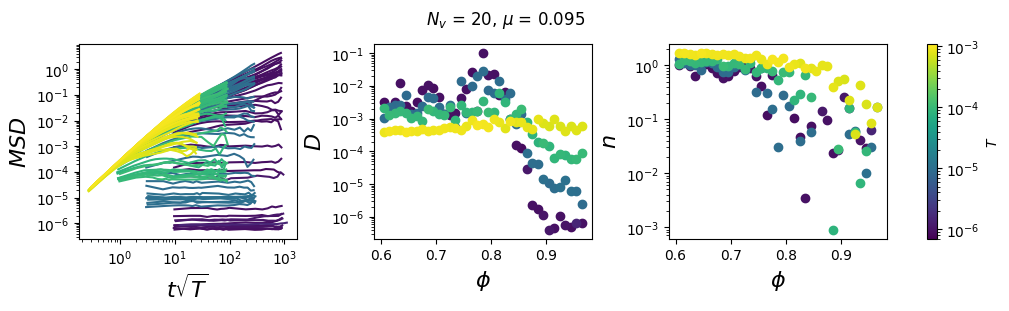

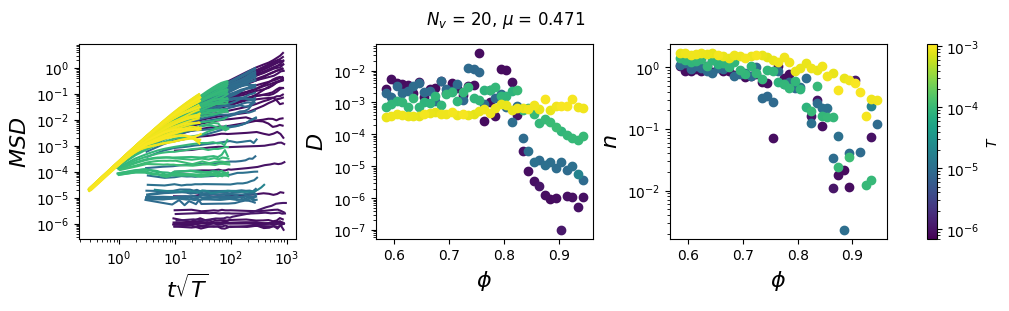

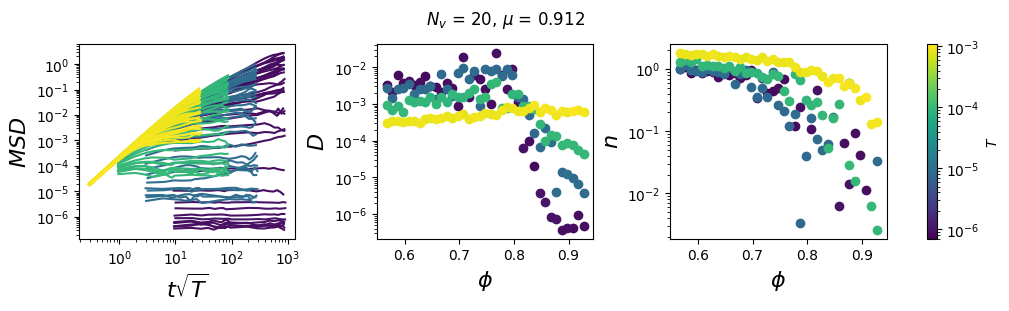

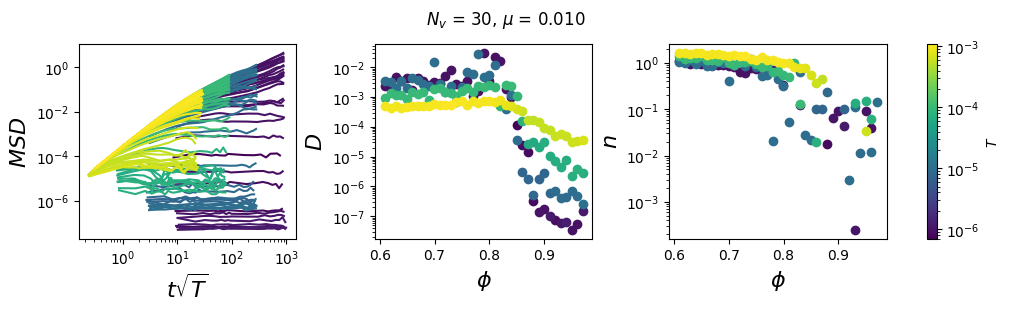

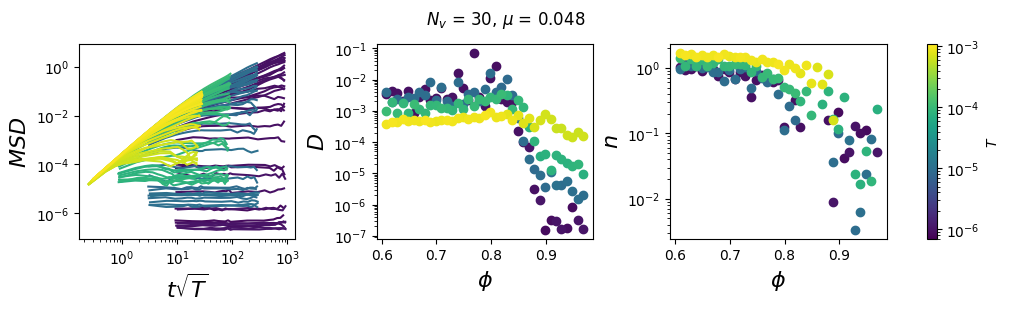

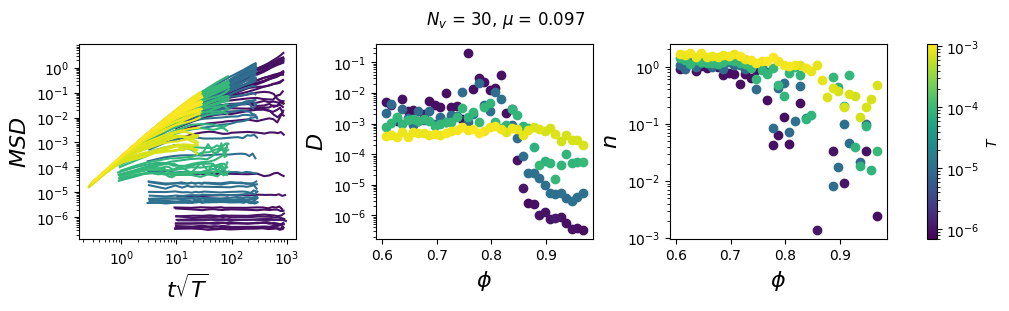

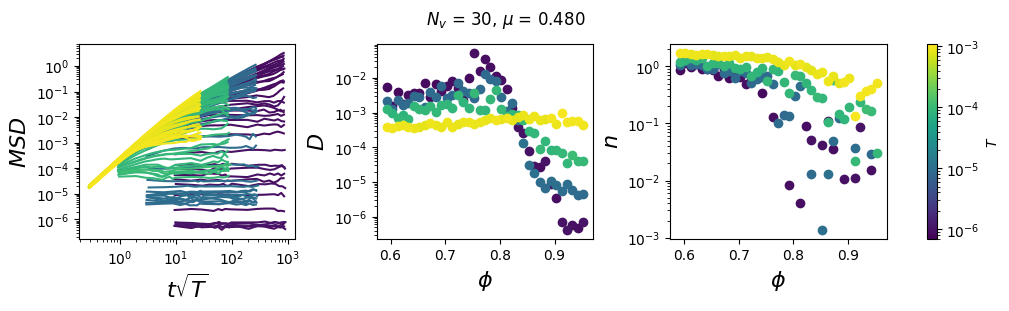

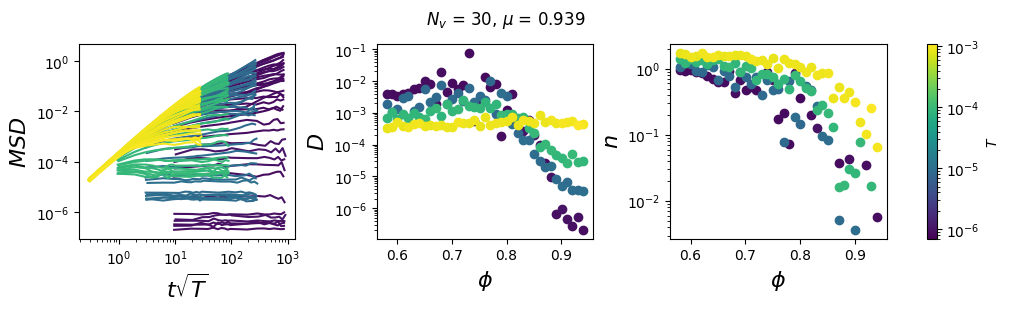

In [355]:
for include_fit in [True, False]:
    cmap = plt.cm.viridis
    norm = LogNorm(vmin=temp_hist.min(), vmax=temp_hist.max())
    unique_params = np.unique(np.column_stack((nv_hist.flatten(), mu_hist.flatten())), axis=0)
    save_root = 'hp-limit-figures/dynamics-prelim/' + ('fit/' if include_fit else 'no-fit/')
    if not os.path.exists(save_root):
        os.makedirs(save_root)
    for nv, mu in unique_params:
        mask = (nv_hist == nv) & (mu_hist == mu)
        D_n_temp_phi = []
        fig, ax = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)
        for _temp in np.sort(temp_hist[mask]):
            i, j = np.argwhere(temp_hist == _temp)[0]
            ax[0].plot(t_hist[i] * np.sqrt(_temp), msd_hist[i, :, j], c=cmap(norm(_temp)))
            y = msd_hist[i, :, j].copy()
            x = (t_hist[i] * np.sqrt(_temp)).copy()
            fit_mask = x > x.max() / 10
            n, log_D = np.polyfit(np.log10(x[fit_mask]), np.log10(y[fit_mask]), 1)
            D = 10 ** log_D
            D_n_temp_phi.append((D, n, _temp, phi_hist[i, j]))
            if include_fit:
                ax[0].plot(x, D * x ** n, label='fit', c='k', zorder=0, lw=0.5, ls='--')
        for D, n, _temp, _phi in D_n_temp_phi:
            ax[1].scatter(_phi, D, color=cmap(norm(_temp)))
            ax[2].scatter(_phi, n, color=cmap(norm(_temp)))
        for a in ax:
            a.set_yscale('log')
        ax[0].set_ylabel(r'$MSD$', fontsize=16)
        ax[0].set_xlabel(r'$t \sqrt{T}$', fontsize=16)
        ax[0].set_xscale('log')
        ax[1].set_ylabel(r'$D$', fontsize=16)
        ax[1].set_xlabel(r'$\phi$', fontsize=16)
        ax[2].set_ylabel(r'$n$', fontsize=16)
        ax[2].set_xlabel(r'$\phi$', fontsize=16)
        plt.suptitle(fr'$N_v$ = {int(nv) - 1}, $\mu$ = {mu:.3f}')
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array(temp_hist[mask])
        cbar = plt.colorbar(sm, ax=ax, label=r'$T$')
        plt.savefig(os.path.join(save_root, f'nv-{int(nv) - 1}-mu-{mu:.3f}.png'), dpi=300)
        plt.show()

Although largely incomplete, the high friction cases are, again, the points to look at.  Here, it seems that in the region where $n~1$ (diffusion roughly obtained), $D$ stops evolving with $T$ at roughly $T<10^{-5}$.

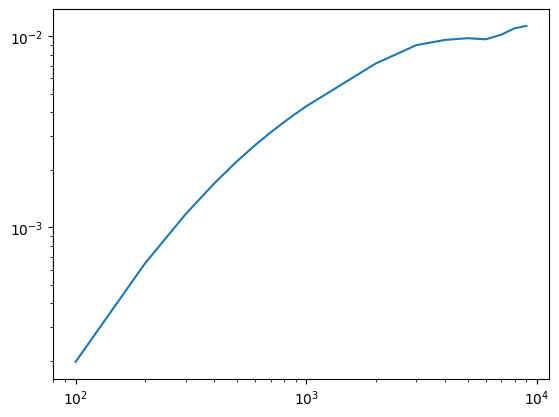

In [194]:
plt.plot(t, msd[:, 0])
plt.xscale('log')
plt.yscale('log')

# Find Optimal $\Delta t$ for each $T$